# Marco Lavorini   -  Assignment 3

In [237]:
import idx2numpy
import numpy as np
from matplotlib import pyplot as plt
import os



def read_idx(filename):
    array = idx2numpy.convert_from_file(filename)
    return array

files = ["train-images.idx3-ubyte", "train-labels.idx1-ubyte", "t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte"]

x_train = read_idx(os.path.join("..", "datasets", "mnist", files[0]))
y_train = read_idx(os.path.join("..", "datasets", "mnist", files[1]))
x_test = read_idx(os.path.join("..", "datasets", "mnist", files[2]))
y_test = read_idx(os.path.join("..", "datasets", "mnist", files[3]))

print(y_train)


[5 0 4 ... 5 6 8]


In [250]:
x_train_b = np.where(x_train > 0, 1, 0)
x_test_b = np.where(x_test > 0, 1, 0)


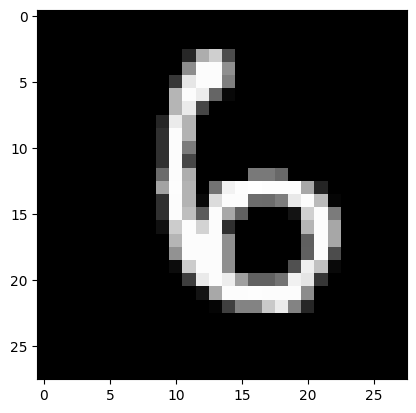

In [252]:
#print first element in data using matplot lib
plt.imshow(x_train[186], cmap='gray')
plt.show()

# Sigmoid function

In [253]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [269]:
class rbm:
    def __init__(self, num_visible, num_hidden):
        self.h = num_hidden
        self.v = num_visible
        self.W = np.random.uniform(-0.05, 0.05, (num_visible, num_hidden))
        self.bh = np.zeros(num_hidden)
        self.bv = np.zeros(num_visible)
    
    def fit(self, X, epochs=10, lr=0.01, batch_size=10):
        print("todo")
        for epoch in range(epochs):
            # wake part
            print('wake')
            pos_def_P = sigmoid(np.dot(X, self.W) + self.bh)

            print(f'pos_def_P shape: {pos_def_P.shape}')
            print(f'max pos_def_P: {np.max(pos_def_P)}')
            print(f'max X: {np.max(X)}')
            
            wake = np.dot(X.T, pos_def_P)
            print(wake)
            print(f'\n\n(max wake: {np.max(wake)}\n\n')
        
            print('dream')
            # dream part
            pos_hid_S = pos_def_P > np.random.rand(len(pos_def_P), len(pos_def_P[0])) # stochastic hidden activation
            recon_data_P = sigmoid(np.dot(pos_hid_S, self.W.T) + self.bv) #reconstructed data

            recon_data = recon_data_P > np.random.rand(len(recon_data_P), len(recon_data_P[0]))
            neg_hid_P = sigmoid(np.dot(recon_data, self.W) + self.bh)
            dream = np.dot(recon_data.T, neg_hid_P)
            print(dream)
            #check
            err = (np.sum(X - recon_data)**2)/len(X)      #check  
            #check

            deltaW = (wake - dream)/len(X)
            deltaBh = (np.sum(pos_def_P) - np.sum(neg_hid_P))/len(X)
            deltaBv = (np.sum(X) - np.sum(recon_data))/len(X)
            self.W += lr * deltaW
            self.bh += lr * deltaBh
            self.bv += lr * deltaBv
            print(f'epoch: {epoch}, err: {err}')

In [270]:
print(x_train.shape)
print(x_train[0].shape)
print(x_train[0].flatten().shape)

(60000, 28, 28)
(28, 28)
(784,)


In [271]:

x_train_flattened = x_train_b.reshape(x_train_b.shape[0], -1)
print(x_train_flattened.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [272]:
print(f'max: {np.max(x_train_flattened[0])}')

max: 1


In [275]:
net = rbm(x_train_flattened.shape[1], 500)
print(f'v = {net.v}')
print(f'h = {net.h}')

v = 784
h = 500


In [283]:
net.fit(x_train_flattened[:1], epochs=50, lr=0.01, batch_size=500)

todo
wake
pos_def_P shape: (1, 500)
max pos_def_P: 0.9943548530249231
max X: 1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(max wake: 0.9943548530249231


dream
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
epoch: 0, err: 1.0
wake
pos_def_P shape: (1, 500)
max pos_def_P: 0.994655140183561
max X: 1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(max wake: 0.994655140183561


dream
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
epoch: 1, err: 0.0
wake
pos_def_P shape: (1, 500)
max pos_def_P: 0.9949674980505524
max X: 1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 

In [207]:
print(net.W)

[[-4.92878969 -4.88463186 -4.92028227 ... -4.87914287 -4.93407747
  -4.9566346 ]
 [-4.9156988  -4.95362048 -4.88481188 ... -4.92023364 -4.92579084
  -4.89613916]
 [-4.95517805 -4.90630974 -4.92170174 ... -4.9164946  -4.9305176
  -4.97445114]
 ...
 [-4.97024071 -4.95044997 -4.88673241 ... -4.87762831 -4.93343288
  -4.91509192]
 [-4.92784807 -4.93330517 -4.94442115 ... -4.93892199 -4.88728181
  -4.94654557]
 [-4.9117743  -4.95208794 -4.93144558 ... -4.95065197 -4.95215234
  -4.88108958]]
